# Introduction

Do higher film budgets lead to more box office revenue? Let's find out if there's a relationship using the movie budgets and financial performance data that I've scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets) on **May 1st, 2018**. 

<img src=https://i.imgur.com/kq7hrEh.png>

# Import Statements

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Notebook Presentation

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Read the Data

In [3]:
data = pd.read_csv('cost_revenue_dirty.csv')

# Explore and Clean the Data

1. How many rows and columns does the dataset contain?
2. Are there any NaN values present?
3. Are there any duplicate rows?
4. What are the data types of the columns?

In [15]:
print(f"Shape: {data.shape}")
print(f"NaN present?: {data.isna().values.any()}")
print(f"Duplicate Rows present?: {len(data[data.duplicated()])}")
data.info()

Shape: (5391, 6)
NaN present?: False
Duplicate Rows present?: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Rank                   5391 non-null   int64 
 1   Release_Date           5391 non-null   object
 2   Movie_Title            5391 non-null   object
 3   USD_Production_Budget  5391 non-null   object
 4   USD_Worldwide_Gross    5391 non-null   object
 5   USD_Domestic_Gross     5391 non-null   object
dtypes: int64(1), object(5)
memory usage: 252.8+ KB


### Data Type Conversions

##### Convert the `USD_Production_Budget`, `USD_Worldwide_Gross`, and `USD_Domestic_Gross` columns to a numeric format by removing `$` signs and `,`. 
Note that *domestic* in this context refers to the United States.

In [35]:
chars_to_remove = [',', '$']
columns_to_clean = ['USD_Production_Budget', 'USD_Worldwide_Gross', 'USD_Domestic_Gross']
 
for col in columns_to_clean:
    for char in chars_to_remove:
        data[col] = data[col].astype(str).str.replace(char, "", regex=True)
    data[col] = pd.to_numeric(data[col])

**Challenge**: Convert the `Release_Date` column to a Pandas Datetime type. 

In [36]:
data.Release_Date = pd.to_datetime(data.Release_Date)

### Descriptive Statistics

1. What is the average production budget of the films in the data set?
2. What is the average worldwide gross revenue of films?
3. What were the minimums for worldwide and domestic revenue?
4. Are the bottom 25% of films actually profitable or do they lose money?
5. What are the highest production budget and highest worldwide gross revenue of any film?
6. How much revenue did the lowest and highest budget films make?

In [68]:
avg_prod_budget = data.USD_Production_Budget.sum() / len(data.USD_Production_Budget)
print(f"Average production budget: {round(avg_prod_budget, 2)}")

avg_gross_revenue = data.USD_Worldwide_Gross.sum() / len(data.USD_Worldwide_Gross)
print(f"Average worldwide gross revenue : {round(avg_gross_revenue, 2)}")

print(f"Minimum worldwide revenue: ${data.USD_Worldwide_Gross.min()}")
print(f"Minimum domestic revenue: ${data.USD_Domestic_Gross.min()}")


print(f"Highest prod budget: ${data.USD_Production_Budget.max()}")
print(f"Highest gross revenue: ${data.USD_Worldwide_Gross.max()}")

# print(data[data.USD_Production_Budget == 425000000])
print(f"Revenue of high budget film: {data[data.USD_Production_Budget == 425000000]}")
# print(f"Highest prod budget: ${data.USD_Production_Budget.min()}")
print(f"Revenue of low budget film: {data[data.USD_Production_Budget == 0]}")

Average production budget: 31113737.58
Average worldwide gross revenue : 88855421.96
Minimum worldwide revenue: $0
Minimum domestic revenue: $0
Highest prod budget: $425000000
Highest gross revenue: $2783918982
Revenue of high budget film:       Rank Release_Date Movie_Title  USD_Production_Budget  \
3529     1   2009-12-18      Avatar              425000000   

      USD_Worldwide_Gross  USD_Domestic_Gross  
3529           2783918982           760507625  
Highest prod budget: $1100
Revenue of low budget film: Empty DataFrame
Columns: [Rank, Release_Date, Movie_Title, USD_Production_Budget, USD_Worldwide_Gross, USD_Domestic_Gross]
Index: []


# Investigating the Zero Revenue Films

##### How many films grossed $0 domestically (i.e., in the United States)? What were the highest budget films that grossed nothing?

In [70]:
len(data[data.USD_Domestic_Gross == 0])

512

##### How many films grossed $0 worldwide? What are the highest budget films that had no revenue internationally?

In [73]:
print(f"Number of films grossing $0 worldwide: {len(data[data.USD_Worldwide_Gross == 0])}\n\n")
zero_revenue = data[data.USD_Worldwide_Gross == 0]
zero_revenue.sort_values('USD_Production_Budget', ascending=False)

Number of films grossing $0 worldwide: 357




,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,175000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5058,880,2015-11-12,The Ridiculous 6,60000000,0,0
...,...,...,...,...,...,...
4787,5371,2014-12-31,Stories of Our Lives,15000,0,0
3056,5374,2007-12-31,Tin Can Man,12000,0,0
4907,5381,2015-05-19,Family Motocross,10000,0,0
5006,5389,2015-09-29,Signed Sealed Delivered,5000,0,0


### Filtering on Multiple Conditions

In [75]:
international_releases = data.loc[(data.USD_Domestic_Gross == 0) & (data.USD_Worldwide_Gross != 0)]
international_releases.head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
71,4310,1956-02-16,Carousel,3380000,3220,0
1579,5087,2001-02-11,Everything Put Together,500000,7890,0
1744,3695,2001-12-31,The Hole,7500000,10834406,0
2155,4236,2003-12-31,Nothing,4000000,63180,0
2203,2513,2004-03-31,The Touch,20000000,5918742,0


##### Use the [`.query()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) to accomplish the same thing. Create a subset for international releases that had some worldwide gross revenue, but made zero revenue in the United States. 

Hint: This time you'll have to use the `and` keyword.

In [76]:
international_releases = data.query('USD_Domestic_Gross == 0 and USD_Worldwide_Gross != 0')
international_releases.head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
71,4310,1956-02-16,Carousel,3380000,3220,0
1579,5087,2001-02-11,Everything Put Together,500000,7890,0
1744,3695,2001-12-31,The Hole,7500000,10834406,0
2155,4236,2003-12-31,Nothing,4000000,63180,0
2203,2513,2004-03-31,The Touch,20000000,5918742,0


### Unreleased Films
* Identify which films were not released yet as of the time of data collection (May 1st, 2018).
* How many films are included in the dataset that have not yet had a chance to be screened in the box office? 
* Create another DataFrame called data_clean that does not include these films. 

In [78]:
# Date of Data Collection
scrape_date = pd.Timestamp('2018-5-1')

In [81]:
future_releases = data[data.Release_Date >= scrape_date]
# future_releases
clean_data = data.drop(future_releases.index)

### Films that Lost Money 
What is the percentage of films where the production costs exceeded the worldwide gross revenue? 

In [85]:
films_losing_money = clean_data.query('USD_Production_Budget > USD_Worldwide_Gross')
(films_losing_money.shape[0]/clean_data.shape[0])*100

# (or)
# films_losing_money = clean_data.loc[clean_data.USD_Production_Budget > clean_data.USD_Worldwide_Gross]
# len(films_losing_money)/len(clean_data)

37.27711738484398

# Seaborn for Data Viz: Bubble Charts

<Axes: xlabel='USD_Production_Budget', ylabel='USD_Worldwide_Gross'>

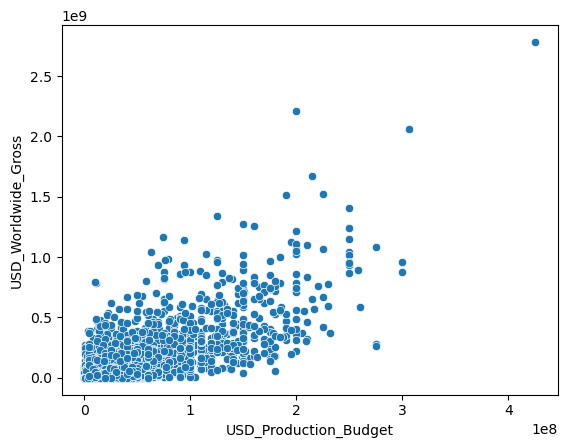

In [90]:
sns.scatterplot(data=clean_data, x='USD_Production_Budget', y='USD_Worldwide_Gross')

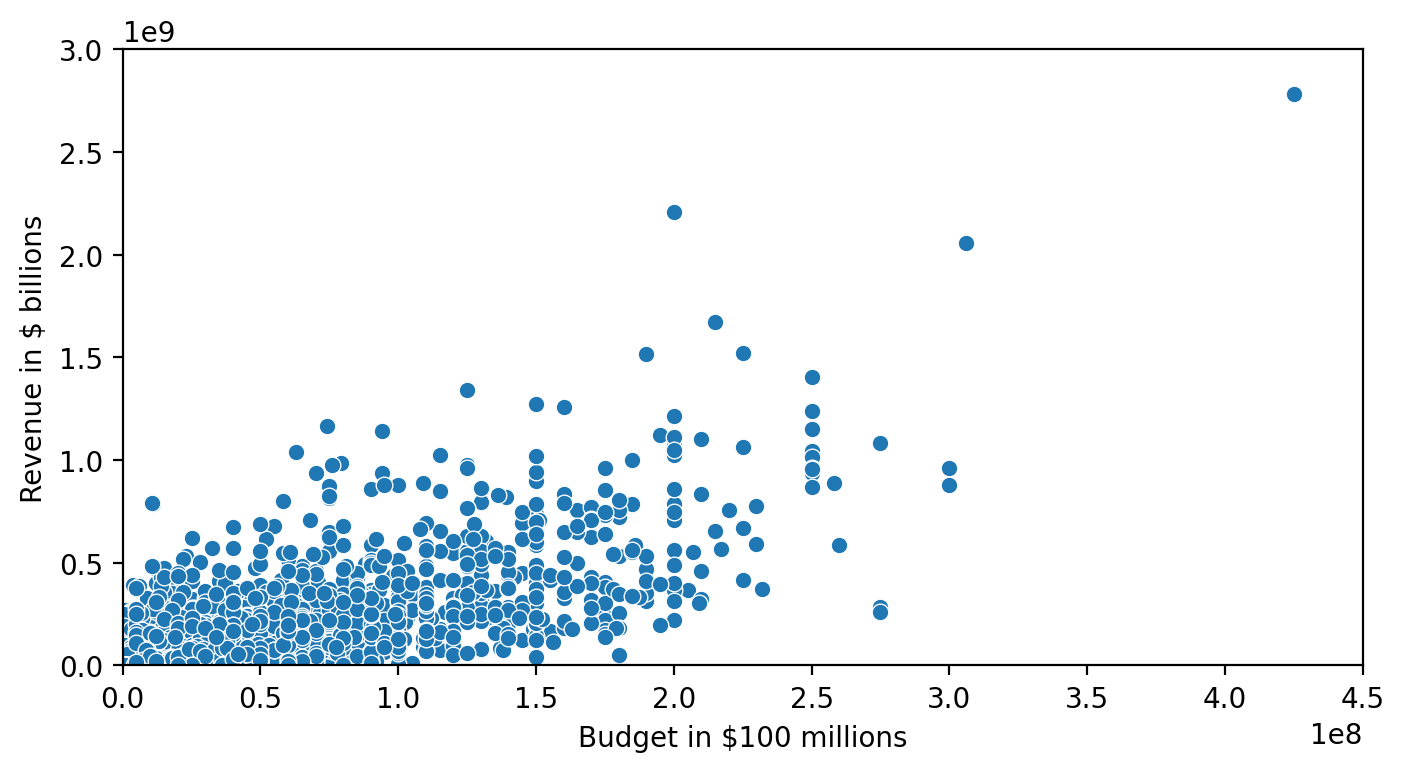

In [99]:
plt.figure(figsize=(8,4), dpi=200)
ax = sns.scatterplot(data=clean_data, x='USD_Production_Budget', y='USD_Worldwide_Gross')
ax.set(ylim=(0, 3000000000),
       xlim=(0, 450000000),
       ylabel='Revenue in $ billions',
       xlabel='Budget in $100 millions')
plt.show()

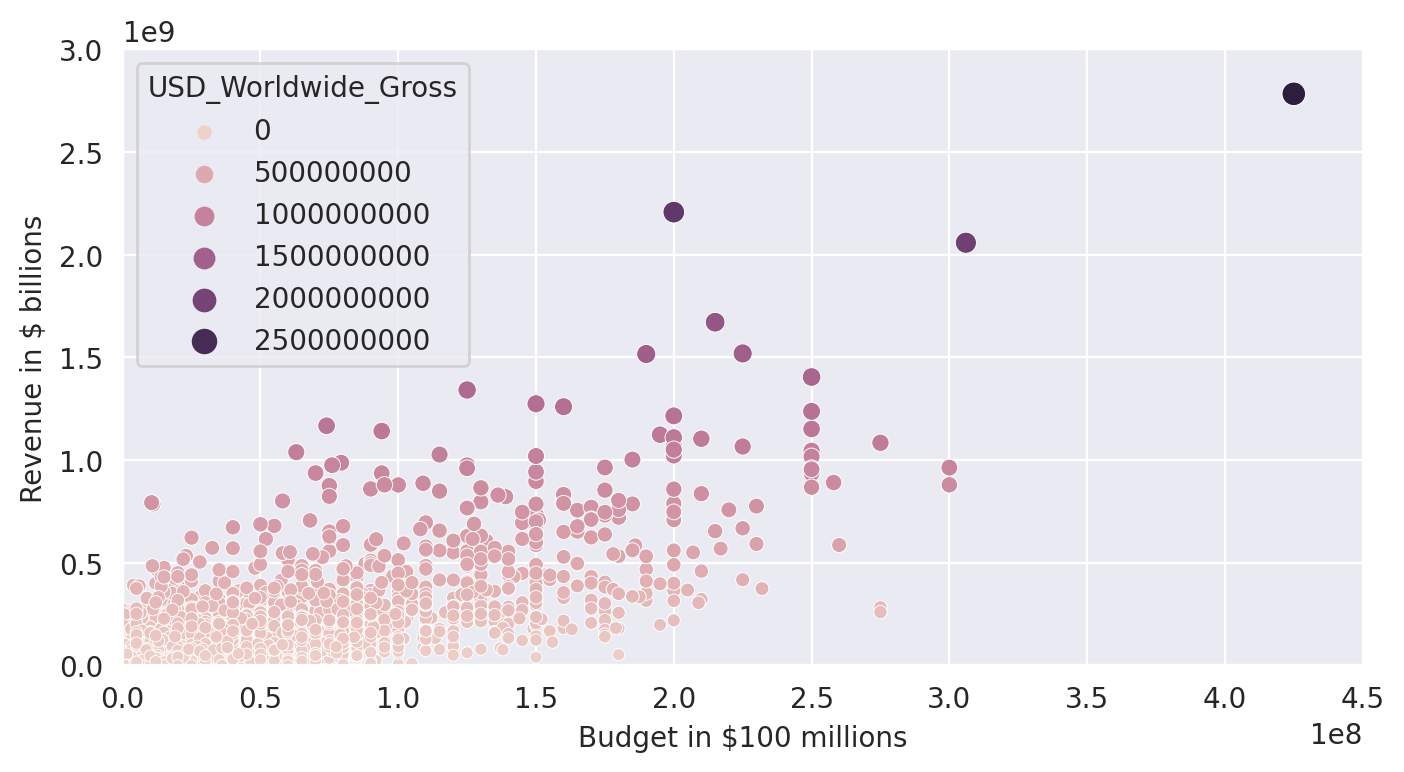

In [105]:
plt.figure(figsize=(8,4), dpi=200)
 
# set styling on a single chart
with sns.axes_style('darkgrid'):
  ax = sns.scatterplot(data=clean_data,
                       x='USD_Production_Budget', 
                       y='USD_Worldwide_Gross',
                       hue='USD_Worldwide_Gross',
                       size='USD_Worldwide_Gross')
 
  ax.set(ylim=(0, 3000000000),
        xlim=(0, 450000000),
        ylabel='Revenue in $ billions',
        xlabel='Budget in $100 millions')

### Plotting Movie Releases over Time

**Challenge**: Try to create the following Bubble Chart:

<img src=https://i.imgur.com/8fUn9T6.png>



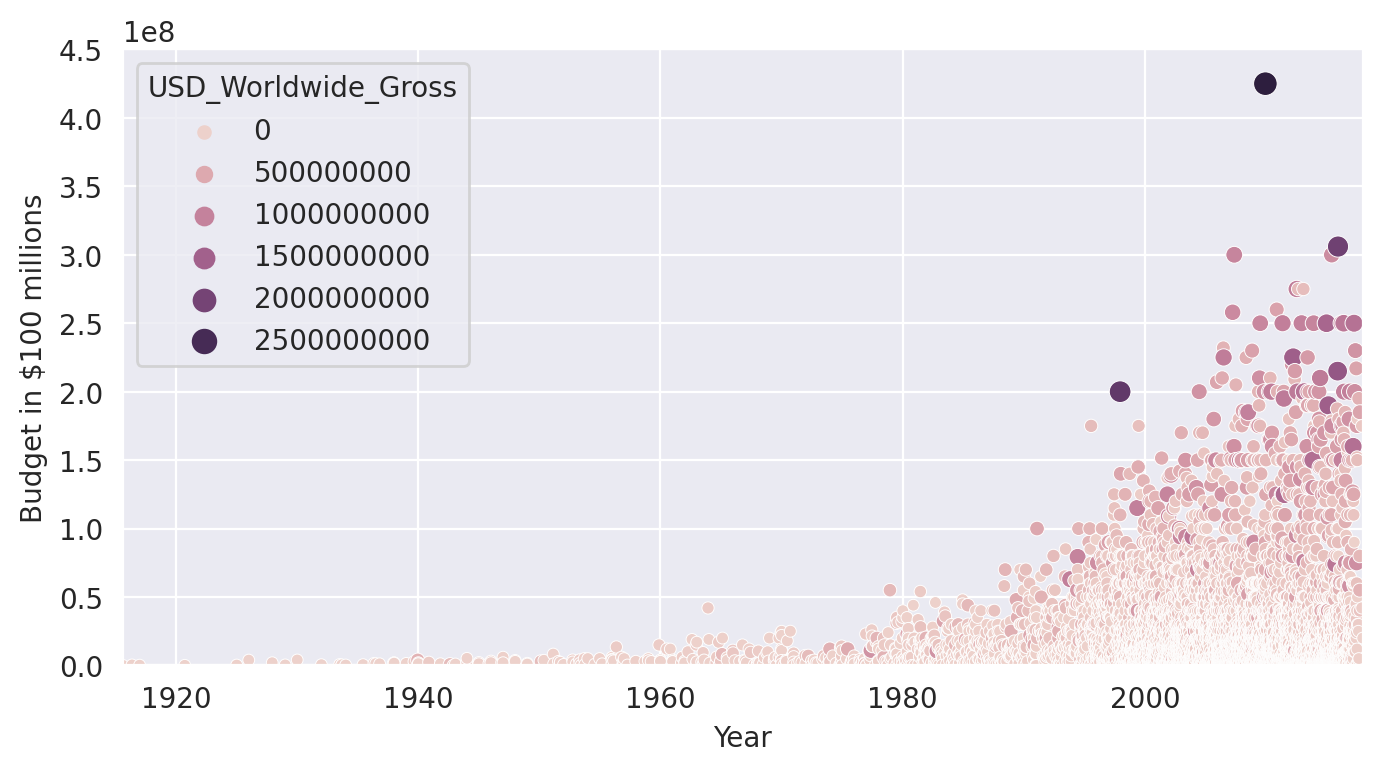

In [107]:
plt.figure(figsize=(8,4), dpi=200)
 
with sns.axes_style("darkgrid"):
    ax = sns.scatterplot(data=clean_data, 
                    x='Release_Date', 
                    y='USD_Production_Budget',
                    hue='USD_Worldwide_Gross',
                    size='USD_Worldwide_Gross',)
 
    ax.set(ylim=(0, 450000000),
           xlim=(clean_data.Release_Date.min(), clean_data.Release_Date.max()),
           xlabel='Year',
           ylabel='Budget in $100 millions')

# Converting Years to Decades Trick

**Challenge**: Create a column in `data_clean` that has the decade of the release. 

<img src=https://i.imgur.com/0VEfagw.png width=650> 

Here's how: 
1. Create a [`DatetimeIndex` object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) from the Release_Date column. 
2. Grab all the years from the `DatetimeIndex` object using the `.year` property.
<img src=https://i.imgur.com/5m06Ach.png width=650>
3. Use floor division `//` to convert the year data to the decades of the films.
4. Add the decades as a `Decade` column to the `data_clean` DataFrame.

In [111]:
dt_index = pd.DatetimeIndex(clean_data.Release_Date)
years = dt_index.year
decades = years//10 * 10
clean_data['Decade'] = decades
clean_data.head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Decade
0,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000,1910
1,5140,1916-05-09,Intolerance,385907,0,0,1910
2,5230,1916-12-24,"20,000 Leagues Under the Sea",200000,8000000,8000000,1910
3,5299,1920-09-17,Over the Hill to the Poorhouse,100000,3000000,3000000,1920
4,5222,1925-01-01,The Big Parade,245000,22000000,11000000,1920


### Separate the "old" (before 1969) and "New" (1970s onwards) Films

**Challenge**: Create two new DataFrames: `old_films` and `new_films`
* `old_films` should include all the films before 1969 (up to and including 1969)
* `new_films` should include all the films from 1970 onwards
* How many films were released prior to 1970?
* What was the most expensive film made prior to 1970?

In [115]:
old_films = clean_data[clean_data.Decade <= 1960]
new_films = clean_data[clean_data.Decade > 1960]
old_films.describe()

,Rank,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Decade
count,153.00,153.00,153.00,153.00,153.00
mean,"4,274.77","4,611,297.65","30,419,634.38","22,389,473.87","1,949.15"
std,742.14,"5,713,648.85","54,931,828.93","32,641,752.41",12.72
min,"1,253.00","100,000.00",0.00,0.00,"1,910.00"
25%,"3,973.00","1,250,000.00","5,273,000.00","5,000,000.00","1,940.00"
50%,"4,434.00","2,900,000.00","10,000,000.00","10,000,000.00","1,950.00"
75%,"4,785.00","5,000,000.00","33,208,099.00","28,350,000.00","1,960.00"
max,"5,299.00","42,000,000.00","390,525,192.00","198,680,470.00","1,960.00"


# Seaborn Regression Plots

<Axes: xlabel='USD_Production_Budget', ylabel='USD_Worldwide_Gross'>

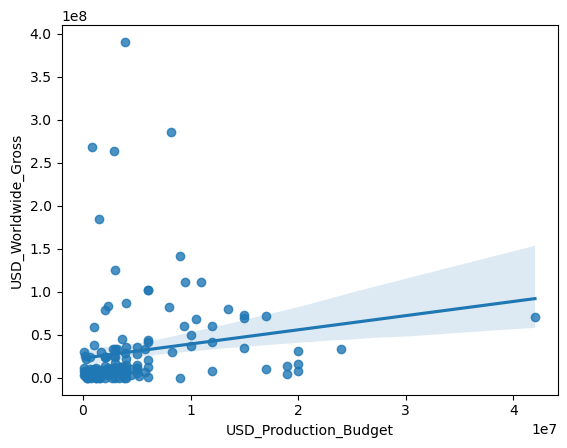

In [116]:
sns.regplot(data=old_films, 
            x='USD_Production_Budget',
            y='USD_Worldwide_Gross')

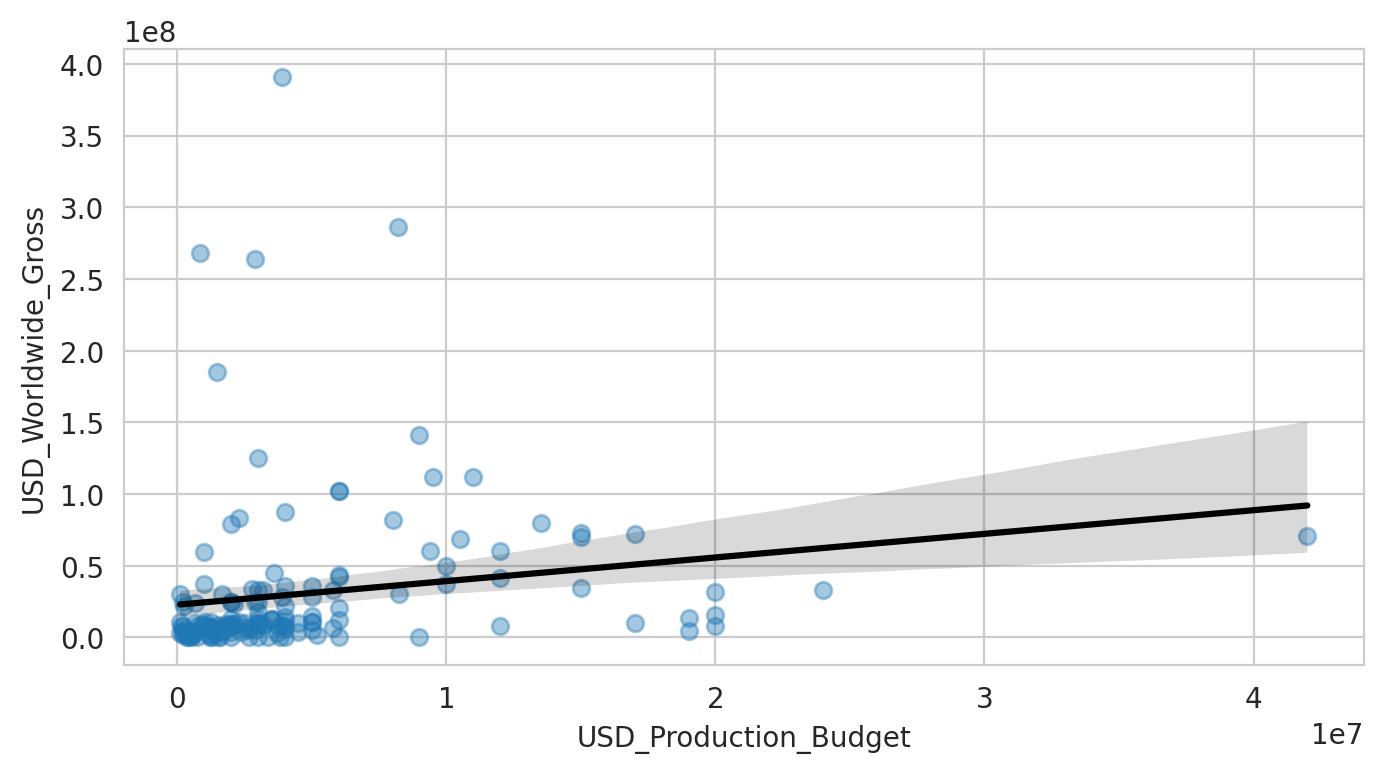

In [117]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style("whitegrid"):
  sns.regplot(data=old_films, 
            x='USD_Production_Budget', 
            y='USD_Worldwide_Gross',
            scatter_kws = {'alpha': 0.4},
            line_kws = {'color': 'black'})

**Challenge**: Use Seaborn's `.regplot()` to show the scatter plot and linear regression line against the `new_films`. 
<br>
<br>
Style the chart

* Put the chart on a `'darkgrid'`.
* Set limits on the axes so that they don't show negative values.
* Label the axes on the plot "Revenue in \$ billions" and "Budget in \$ millions".
* Provide HEX colour codes for the plot and the regression line. Make the dots dark blue (#2f4b7c) and the line orange (#ff7c43).

Interpret the chart

* Do our data points for the new films align better or worse with the linear regression than for our older films?
* Roughly how much would a film with a budget of $150 million make according to the regression line?

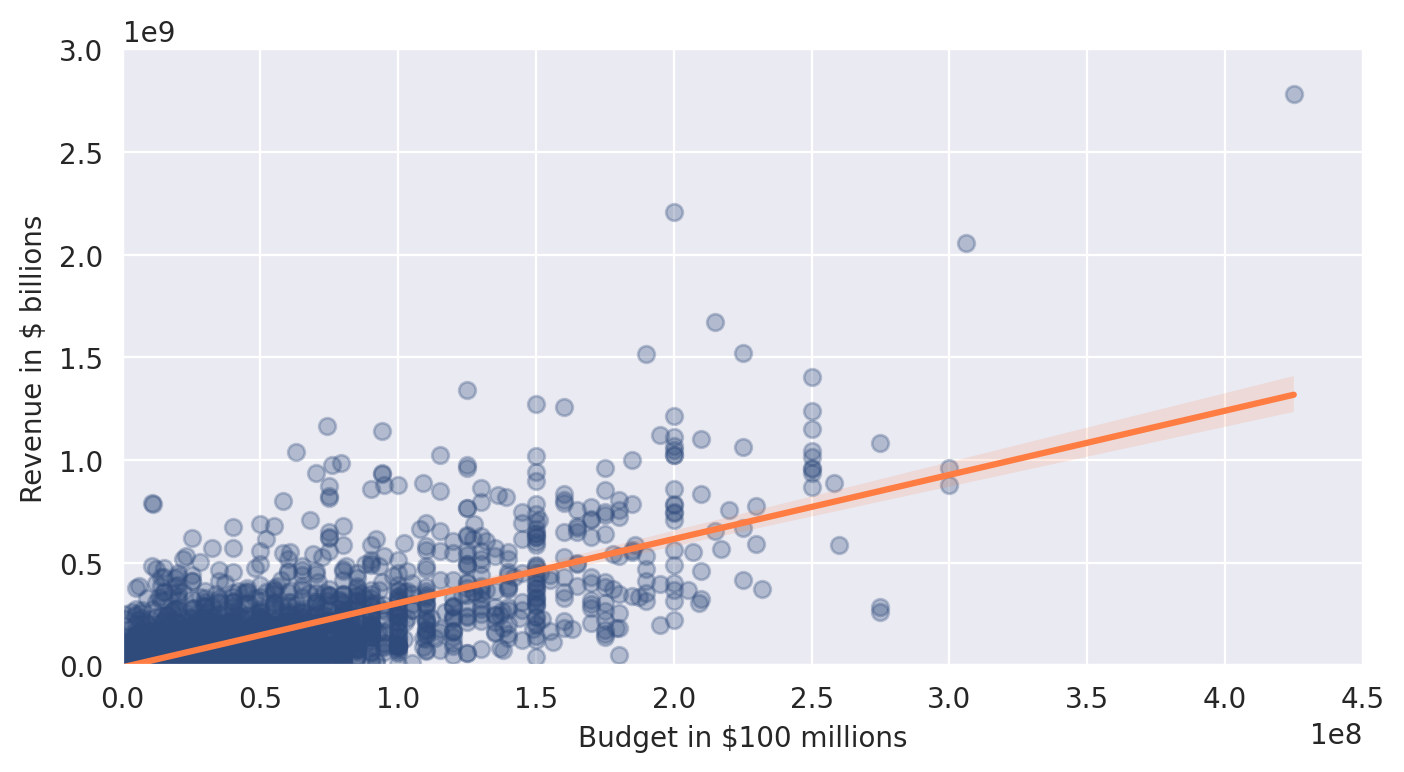

In [120]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style('darkgrid'):
  ax = sns.regplot(data=new_films,
                   x='USD_Production_Budget',
                   y='USD_Worldwide_Gross',
                   color='#2f4b7c',
                   scatter_kws = {'alpha': 0.3},
                   line_kws = {'color': '#ff7c43'})
  
  ax.set(ylim=(0, 3000000000),
         xlim=(0, 450000000),
         ylabel='Revenue in $ billions',
         xlabel='Budget in $100 millions') 

# Run Your Own Regression with scikit-learn

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$


**Challenge**: Run a linear regression for the `old_films`. Calculate the intercept, slope and r-squared. How much of the variance in movie revenue does the linear model explain in this case?

In [129]:
regression = LinearRegression()

# LinearRegression does not like receiving Pandas Series (e.g., new_films.USD_Production_Budget), so I've created new DataFrames 
# Explanatory Variable(s) or Feature(s)
X = pd.DataFrame(new_films, columns=['USD_Production_Budget'])
 
# Response Variable or Target
y = pd.DataFrame(new_films, columns=['USD_Worldwide_Gross']) 

regression.fit(X, y)

# theta-zero
print(regression.intercept_)
# theta-one
regression.coef_

# R-Squared
print(regression.score(X, y))


[-8650768.00661024]
0.5577032617720403


# Use Your Model to Make a Prediction

We just estimated the slope and intercept! Remember that our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

**Challenge**:  How much global revenue does our model estimate for a film with a budget of $350 million? 

In [130]:
budget = 350000000
revenue_estimate = regression.intercept_[0] + regression.coef_[0,0]*budget
revenue_estimate = round(revenue_estimate, -6)
print(f'The estimated revenue for a $350 film is around ${revenue_estimate:.10}.')

The estimated revenue for a $350 film is around $1.084e+09.
